In [1]:
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb
import gc

import lsst.afw.display as afwDisplay
from lsst.afw.image import MultibandExposure
from lsst.daf.butler import Butler
#from lsst.rsp import get_tap_service
import lsst.geom as geom

In [2]:
import lsst.daf.persistence as dp

repo = "/sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/rerun/run2.2i-coadd-wfd-dr6-v1"
butler = dp.Butler(repo)

/tmp/ipykernel_2526/374190624.py:4: FutureWarning: Gen2 Butler has been deprecated (Butler).  This Gen2 code may be removed in any future daily or weekly release. For a Gen3-based Getting Started Tutorial, please see https://pipelines.lsst.io/getting-started/index.html.
  butler = dp.Butler(repo)
/tmp/ipykernel_2526/374190624.py:4: FutureWarning: Gen2 Butler has been deprecated (ImsimMapper).  This Gen2 code may be removed in any future daily or weekly release. For a Gen3-based Getting Started Tutorial, please see https://pipelines.lsst.io/getting-started/index.html.
  butler = dp.Butler(repo)


lsst.CameraMapper INFO: Loading exposure registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/registry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/CALIB/calibRegistry.sqlite3
LsstCamMapper WARN: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading calib registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading exposure registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/registry.sqlite3
lsst.CameraMapper INFO: Loading calib registry from /sps/lsst/dataproducts/desc/DC2/Run2.2i/v19.0.0-v1/CALIB/calibRegistry.sqlite3
lsst.CameraMapper INFO: Loading calib

In [3]:
afwDisplay.setDefaultBackend('matplotlib')

In [4]:
#butler.getDatasetTypes()

In [5]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

In [6]:
def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, verbose=False, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    
    print(tractInfo, patchInfo)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)
    
    #coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    coaddId = {'tract': tractInfo.getId(),'patch': str(patchInfo.getIndex().x)+','+str(patchInfo.getIndex().y), 'filter': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType,dataId=coaddId).subset(bbox)
    #cutout_image = butler.get(datasetType, parameters=parameters,
    #                          dataId=coaddId)
    
    if verbose:
        print(xy)
        print(coaddId)
        print(bbox)
        
    return cutout_image,xy

In [7]:
def create_rgb(image, bgr="gri", stretch=1, Q=10, scale=None):
    """
    Create an RGB color composite image.

    Parameters
    ----------
    image : `MultibandExposure`
        `MultibandExposure` to display.
    bgr : sequence
        A 3-element sequence of filter names (i.e., keys of the exps dict)
        indicating what band to use for each channel. If `image` only has
        three filters then this parameter is ignored and the filters
        in the image are used.
    stretch: int
        The linear stretch of the image.
    Q: int
        The Asinh softening parameter.
    scale: list of 3 floats, each less than 1. (default: None)
        Re-scales the RGB channels.

    Returns
    -------
    rgb: ndarray
        RGB (integer, 8-bits per channel) colour image as an NxNx3 numpy array.
    """

    # If the image only has 3 bands, reverse the order of the bands
    #   to produce the RGB image
    if len(image) == 3:
        bgr = image.filters

    # Extract the primary image component of each Exposure with the
    #   .image property, and use .array to get a NumPy array view.

    if scale is None:
        r_im = image[bgr[2]].array  # numpy array for the r channel
        g_im = image[bgr[1]].array  # numpy array for the g channel
        b_im = image[bgr[0]].array  # numpy array for the b channel
    else:
        # manually re-scaling the images here
        r_im = image[bgr[2]].array * scale[0]
        g_im = image[bgr[1]].array * scale[1]
        b_im = image[bgr[0]].array * scale[2]

    rgb = make_lupton_rgb(image_r=r_im,
                          image_g=g_im,
                          image_b=b_im,
                          stretch=stretch, Q=Q)
    # "stretch" and "Q" are parameters to stretch and scale the pixel values

    return rgb

## zoom on one of the 7*7 patches

In [8]:
dataId = {'tract': 4026, 'patch': '0,0','filter': 'i'}
datasetType = 'deepCoadd'
coadd = butler.get(datasetType, **dataId)

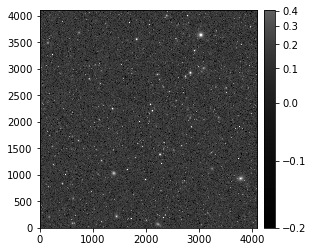

In [9]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(coadd.image)
plt.show()
remove_figure(fig)

In [23]:
datasetType = 'deepCoadd'
coadd_griz = [butler.get(datasetType, {'tract': 4026, 'patch': '0,0', 'filter': x}) for x in ['g','r','i','z']]

In [24]:
coadd_griz = MultibandExposure.fromExposures(['g', 'r', 'i', 'z'], coadd_griz)

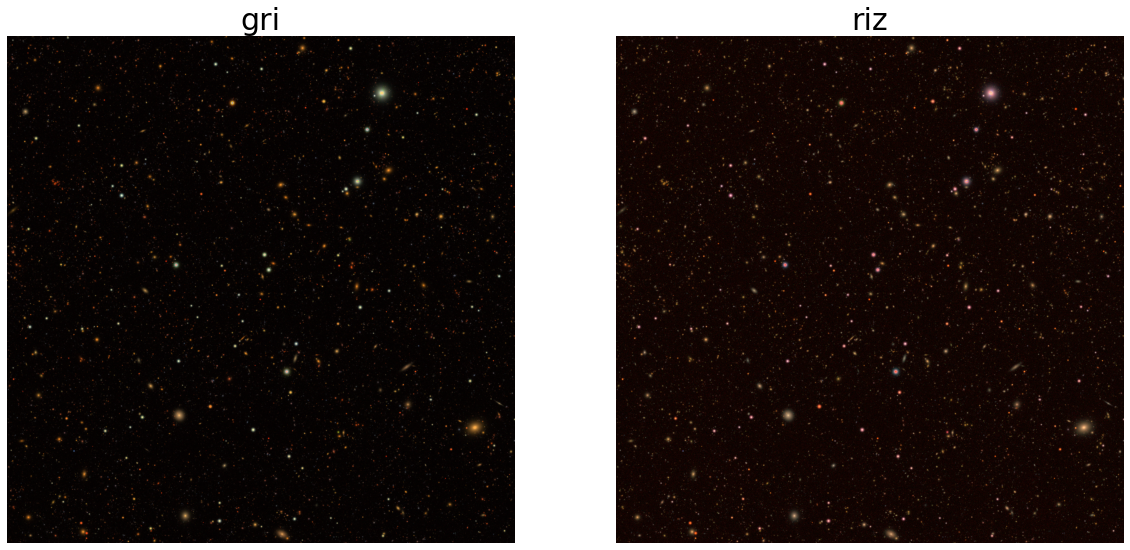

In [26]:
fig, ax = plt.subplots(figsize=(20, 20), nrows=1, ncols=2)

rgb_gri = create_rgb(coadd_griz.image, bgr=['g', 'r', 'i'], scale=None)
ax[0].imshow(rgb_gri, origin='lower')
ax[0].set_title('gri', fontsize=30)

rgb_riz = create_rgb(coadd_griz.image, bgr=['r', 'i', 'z'],
                        scale=None)
ax[1].imshow(rgb_riz, origin='lower')
ax[1].set_title('riz', fontsize=30)

ax[0].set_axis_off()
ax[1].set_axis_off()
plt.show()
remove_figure(fig)

## zoom on a cluster

In [10]:
skymap = butler.get('deepCoadd_skyMap')

In [11]:
ra_cl, dec_cl = 56.75, -32.5

In [12]:
cutoutSideLength_cl=501

cutout_image_cl,xy= cutout_coadd(butler, ra_cl, dec_cl, band='i', datasetType='deepCoadd', skymap=skymap,
                            cutoutSideLength=cutoutSideLength_cl)
print("The size of the cutout in pixels is: ", cutout_image_cl.image.array.shape)

print("The size of the cutout in arcsec is: ", cutout_image_cl.image.array.shape[0]*0.2,cutout_image_cl.image.array.shape[1]*0.2)

TractInfo(id=4432) PatchInfo(index=Index2D(x=5, y=1))
The size of the cutout in pixels is:  (501, 501)
The size of the cutout in arcsec is:  100.2 100.2


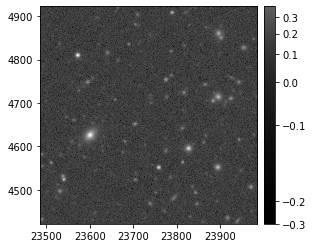

In [13]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout_image_cl.image)
plt.show()
remove_figure(fig)

In [14]:
cutout_image_cl_griz = [cutout_coadd(butler, ra_cl, dec_cl, band=x, datasetType='deepCoadd',skymap=skymap,
                            cutoutSideLength=cutoutSideLength_cl)[0] for x in ['g','r','i','z']]

TractInfo(id=4432) PatchInfo(index=Index2D(x=5, y=1))
TractInfo(id=4432) PatchInfo(index=Index2D(x=5, y=1))
TractInfo(id=4432) PatchInfo(index=Index2D(x=5, y=1))
TractInfo(id=4432) PatchInfo(index=Index2D(x=5, y=1))


In [15]:
cutout_image_cl_griz = MultibandExposure.fromExposures(['g', 'r', 'i','z'], cutout_image_cl_griz)

In [30]:
cutoutSideLength_cl/2, cutoutSideLength_cl/2

(250.5, 250.5)

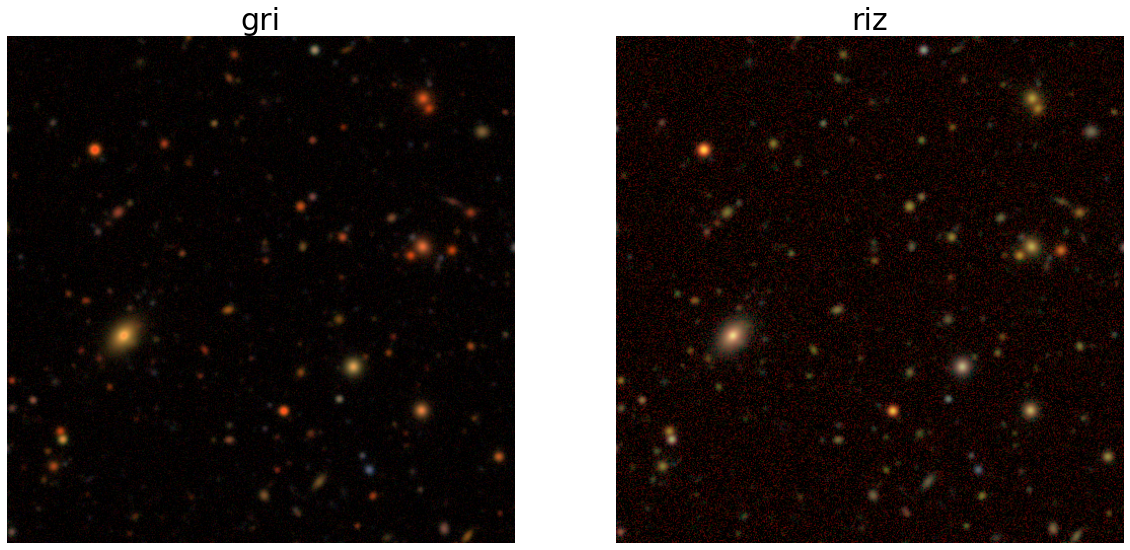

In [36]:
fig, ax = plt.subplots(figsize=(20, 20), nrows=1, ncols=2)

rgb_gri = create_rgb(cutout_image_cl_griz.image, bgr=['g', 'r', 'i'], scale=None)
ax[0].imshow(rgb_gri, origin='lower')
ax[0].set_title('gri', fontsize=30)

rgb_riz = create_rgb(cutout_image_cl_griz.image, bgr=['r', 'i', 'z'],
                        scale=None)
ax[1].imshow(rgb_riz, origin='lower')
ax[1].set_title('riz', fontsize=30)

ax[0].set_axis_off()
ax[1].set_axis_off()
plt.show()
remove_figure(fig)

## zoom on a galaxy

In [18]:
ra_gal, dec_gal = 56.5, -34.2

In [19]:
cutoutSideLength_gal=101

cutout_image_gal,xy_gal= cutout_coadd(butler, ra_gal, dec_gal, band='i', datasetType='deepCoadd', skymap=skymap,
                            cutoutSideLength=cutoutSideLength_gal)
print("The size of the cutout in pixels is: ", cutout_image_gal.image.array.shape)

print("The size of the cutout in arcsec is: ", cutout_image_gal.image.array.shape[0]*0.2,cutout_image_gal.image.array.shape[1]*0.2)

TractInfo(id=4227) PatchInfo(index=Index2D(x=3, y=0))
The size of the cutout in pixels is:  (101, 101)
The size of the cutout in arcsec is:  20.200000000000003 20.200000000000003


In [20]:
cutout_image_gal_griz = [cutout_coadd(butler, ra_gal, dec_gal, band=x, datasetType='deepCoadd', skymap=skymap,
                            cutoutSideLength=cutoutSideLength_gal)[0] for x in ['g','r','i','z']]

TractInfo(id=4227) PatchInfo(index=Index2D(x=3, y=0))
TractInfo(id=4227) PatchInfo(index=Index2D(x=3, y=0))
TractInfo(id=4227) PatchInfo(index=Index2D(x=3, y=0))
TractInfo(id=4227) PatchInfo(index=Index2D(x=3, y=0))


In [21]:
cutout_image_gal_griz = MultibandExposure.fromExposures(['g', 'r', 'i','z'], cutout_image_gal_griz)

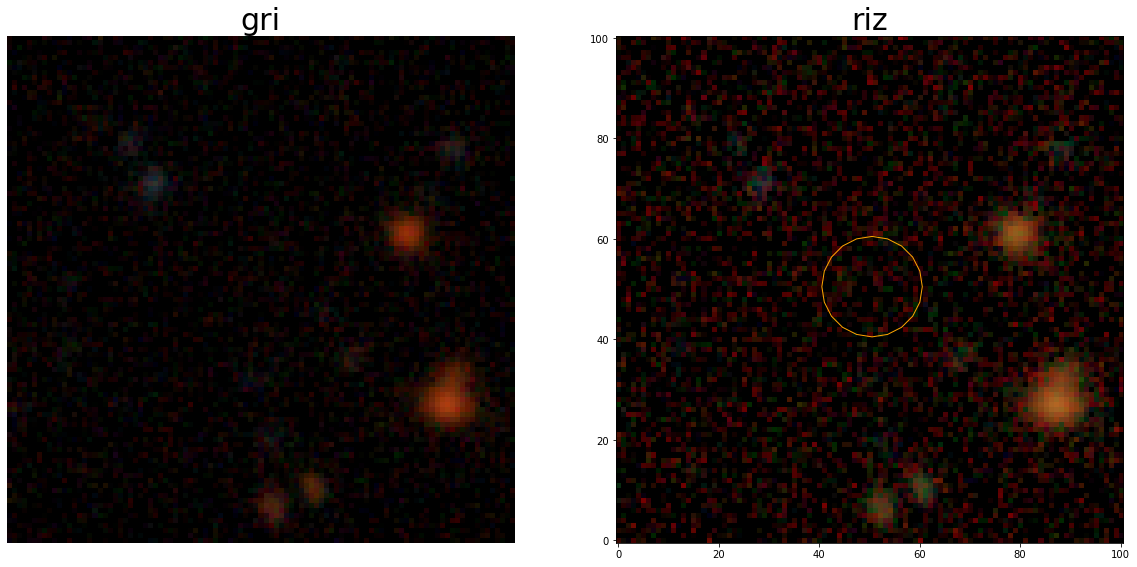

In [22]:
fig, ax = plt.subplots(figsize=(20, 20), nrows=1, ncols=2)

display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')

rgb_gri = create_rgb(cutout_image_gal_griz.image, bgr=['g', 'r', 'i'], scale=None)
ax[0].imshow(rgb_gri, origin='lower')
ax[0].set_title('gri', fontsize=30)

rgb_riz = create_rgb(cutout_image_gal_griz.image, bgr=['r', 'i', 'z'],
                        scale=None)
ax[1].imshow(rgb_riz, origin='lower')
ax[1].set_title('riz', fontsize=30)
display.dot('o', cutoutSideLength_gal/2, cutoutSideLength_gal/2, size=10, ctype='orange')

ax[0].set_axis_off()
#ax[1].set_axis_off()
plt.show()
remove_figure(fig)